# Analysis of Ngn2, Isl1, and Lhx3 titration

## Load data
Notes:

1. Only singlets are included

In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from matplotlib.ticker import ScalarFormatter
from pathlib import Path
import re
import seaborn as sns
import scipy
from statannotations.Annotator import Annotator
import rushd as rd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Required descriptors for annotate
from statannotations.stats.StatTest import StatTest
from scipy.stats import ttest_ind
custom_long_name = 't-test for independent samples from scipy with greater 1-way (mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample)'
custom_short_name = 't-test_ind_greater'
custom_func = ttest_ind
ttest_ind_greater = StatTest(custom_func, custom_long_name, custom_short_name, alternative='greater')

custom_long_name = 't-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample)'
custom_short_name = 't-test_ind_less'
custom_func = ttest_ind
ttest_ind_less = StatTest(custom_func, custom_long_name, custom_short_name, alternative='less')

# Look at 4 dpi data

## Load data

In [10]:
# Directories
base_datadir = rd.datadir/'2023.02.20_HG_NIL-titrate_4dpi'
figpath = '../figures/fi5/'

# List of data folder names
dir_list = ['2023.02.20_HG_NIL-titrate_1_4dpi', '2023.02.20_HG_NIL-titrate_2_4dpi', '2023.03.29_HG_NIL-titrate_3_4dpi', '2023.03.29_HG_NIL-titrate_4_4dpi',
            '2023.11.16_HG_NIL-titrate_7_4dpi', '2023.11.16_HG_NIL-titrate_8_4dpi',]

# List of ctrls and samples
ctrl_list = ['Ctrl-RIDDW', 'Ctrl-puro', 'Ctrl-puro-2A-mRuby2', 'Ctrl-LNIx3HA']
cond_list = ['Ngn2x3HA', 'Isl1', 'Lhx3', 'No Ngn2x3HA', 'No Isl1', 'No Lhx3']

# Store all data in list of dfs which will be converted to df at end
data_4dpi_all = list()

# get all csvs for each dir
for (j, dir_name) in enumerate(dir_list):
    
     # Load as df and note header is on 0th row
    df = rd.flow.load_csv_with_metadata(
        base_datadir/dir_name/'export_singlets_NIL-titrate', base_datadir/'well_metadata.yaml')

    df['rep'] = j
    data_4dpi_all.append(df)
    
# Convert list of dfs into single df
data_4dpi_all = pd.concat(data_4dpi_all, ignore_index=True)

# Remove negative data
data_4dpi_all = data_4dpi_all.loc[
    (data_4dpi_all['eGFP-A'] > 0) &
    (data_4dpi_all['CellTrace™ Violet-A'] > 0) &
    (data_4dpi_all['mRuby2-A'] > 0)
]

# Replace missing data with NA string
data_4dpi_all = data_4dpi_all.fillna("NA")

# Separate out ctrl and sample data
data_4dpi_ctrl = data_4dpi_all[ data_4dpi_all['cond'].isin(ctrl_list) ]
data_4dpi = data_4dpi_all[ data_4dpi_all['cond'].isin(cond_list) ]

# Load in counts

In [14]:
# Directories
base_datadir = rd.datadir/'2023.02.20_HG_NIL-titrate_4dpi'
figpath = '../figures/fig5/'

# List of data folder names
dir_list = ['2023.02.20_HG_NIL-titrate_1_4dpi', '2023.02.20_HG_NIL-titrate_2_4dpi', '2023.03.29_HG_NIL-titrate_3_4dpi', '2023.03.29_HG_NIL-titrate_4_4dpi',
            '2023.10.17_HG_NIL-titrate_5_4dpi', '2023.10.17_HG_NIL-titrate_6_4dpi']

# List of ctrls and samples
ctrl_list = ['Ctrl-RIDDW', 'Ctrl-puro', 'Ctrl-puro-2A-mRuby2', 'Ctrl-LNIx3HA']
cond_list = ['Ngn2x3HA', 'Isl1', 'Lhx3', 'No Ngn2x3HA', 'No Isl1', 'No Lhx3']

# Store all data in list of dfs which will be converted to df at end
data_4dpi_mRuby2_all = list()

# get all csvs for each dir
for (j, dir_name) in enumerate(dir_list):
    
     # Load as df and note header is on 0th row
    df = rd.flow.load_csv_with_metadata(
        base_datadir/dir_name/'export_mRuby2+', base_datadir/'well_metadata.yaml')

    df['rep'] = j
    data_4dpi_mRuby2_all.append(df)
    
# Convert list of dfs into single df
data_4dpi_mRuby2_all = pd.concat(data_4dpi_mRuby2_all, ignore_index=True)

# Remove negative data
data_4dpi_mRuby2_all = data_4dpi_mRuby2_all.loc[
    (data_4dpi_mRuby2_all['eGFP-A'] > 0) &
    (data_4dpi_mRuby2_all['CellTrace™ Violet-A'] > 0) &
    (data_4dpi_mRuby2_all['mRuby2-A'] > 0)
]

# Replace missing data with NA string
data_4dpi_mRuby2_all = data_4dpi_mRuby2_all.fillna("NA")

# Separate out ctrl and sample data
data_4dpi_mRuby2_ctrl = data_4dpi_mRuby2_all[ data_4dpi_mRuby2_all['cond'].isin(ctrl_list) ]
data_4dpi_mRuby2 = data_4dpi_mRuby2_all[ data_4dpi_mRuby2_all['cond'].isin(cond_list) ]

## Categorize cells
### Categorize cells based on CellTrace-Violet

In [15]:
# Get CTV-low threshold for each rep s.t.
# CTV_low_thresh = 20% dimmest in ctrl
rep_list = data_4dpi.rep.unique()
CTV_low_thresh_list = np.zeros(np.shape(rep_list))
for (i, rep) in enumerate(rep_list):
    CTV_low_thresh_list[i] = np.percentile(
        data_4dpi_ctrl.loc[(data_4dpi_ctrl['cond'] == 'Ctrl-puro') &
            (data_4dpi_ctrl['rep'] == rep)
        ]['CellTrace™ Violet-A'], 20)

# Categorize based on CTV for each rep
data_4dpi.loc[:, 'CTV_cat'] = 'CTV-low'
for (i, rep) in enumerate(rep_list):
    data_4dpi.loc[
        (data_4dpi['rep'] == rep_list[i]) &
        (data_4dpi['CellTrace™ Violet-A'] > CTV_low_thresh_list[i]),
        'CTV_cat'] = 'non-CTV-low'

# Calculate CTV populations using these metrics
well_group = ['cond', 'const', 'DDRR_cat', 'uORF', 'rep']
count_df = data_4dpi.groupby([*well_group, 'well', 'CTV_cat'])[
    'FSC-A'].count().unstack(fill_value=0).stack().rename('count') # Puts 0 if none rather than dropping row
CTV_percent_4dpi_reps = (count_df*100/count_df.groupby([*well_group, 'well']
                           ).transform('sum')).reset_index(name='percent')
# Extract just the hyperP

CTV_hyperP_percent_4dpi_reps = CTV_percent_4dpi_reps.loc[(CTV_percent_4dpi_reps['CTV_cat'] == 'CTV-low')]
CTV_hyperP_percent_4dpi = CTV_hyperP_percent_4dpi_reps.groupby(well_group).mean().reset_index()

/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


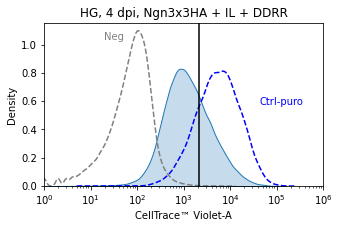

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# Threshold for hyperP
rep = 1
CTV_low_thresh = CTV_low_thresh_list[rep]

# Plot CTV-A
x = 'CellTrace™ Violet-A'
sns.kdeplot(data=data_4dpi.loc[
    (data_4dpi['cond'] == 'Ngn2x3HA') & (data_4dpi['uORF'] == 'uORFx0') & (data_4dpi['rep'] == rep)],
    ax=ax, x=x,
    common_norm=False, log_scale=(True, False),
    fill=True)

# Plot CTV control
sns.kdeplot(data=data_4dpi_ctrl[(data_4dpi_ctrl['cond'] == 'Ctrl-puro') & (data_4dpi_ctrl['rep'] == rep)], x=x, common_norm=False,
            ax=ax, log_scale=(True, False), color='blue', fill=False, linestyle='--')
ax.annotate('Ctrl-puro', (0.85, 0.5), color='blue' , xycoords='axes fraction', ha='center')

# Plot neg ctrl
sns.kdeplot(data=data_4dpi_ctrl[(data_4dpi_ctrl['cond'] == 'Ctrl-RIDDW') & (data_4dpi_ctrl['rep'] == rep)], x=x, common_norm=False,
            ax=ax, log_scale=(True, False), color='grey', fill=False, linestyle='--')
ax.annotate('Neg', (0.25, 0.9), color='grey', xycoords='axes fraction', ha='center')

# Plot threshold
ax.axvline(CTV_low_thresh, 0, 1, color='black')

# Title
plt.title('HG, 4 dpi, Ngn3x3HA + IL + DDRR')
# Adjust limits
CTV_lim = (1, 1*10**6)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(CTV_lim)

/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A v

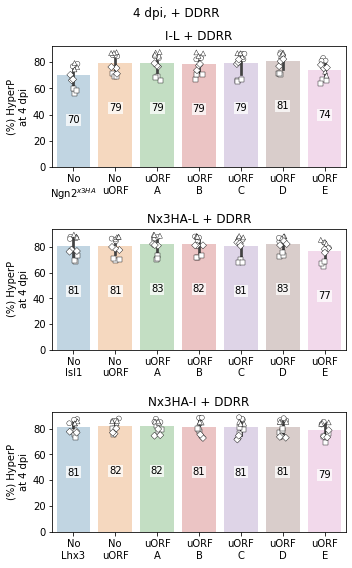

In [43]:
# General plotting params
x = 'uORF'
y = 'percent'
uORF_list = ['uORFx0', 'uORFwx1', 'uORFx1', 'uORFx2', 'uORFx3', 'uORFx6']
cond_list = ['Ngn2x3HA', 'Isl1', 'Lhx3']
const_list = ['I-L', 'Nx3HA-L', 'Nx3HA-I']
units = 'rep'
marker_list = ['o', 's', '^', 'D', 'P', 'X']

# Plot iMN percent of all cells
fig, ax = plt.subplots(len(cond_list), 1, figsize=(5, 8))
for (i, cond) in enumerate(cond_list):

    # Make new df with only const expression ctrl
    onlyConstData = CTV_hyperP_percent_4dpi_reps[(CTV_hyperP_percent_4dpi_reps['cond'] ==  'No {}'.format(cond)) & (CTV_hyperP_percent_4dpi_reps['const'] ==  const_list[i])]
    constData_uORFrename = 'No\n{}'.format(cond)
    onlyConstData.uORF = constData_uORFrename
    onlyConstData.cond = cond

    # Recombine df's
    df = pd.concat([onlyConstData,
                    CTV_hyperP_percent_4dpi_reps.loc[(CTV_hyperP_percent_4dpi_reps.cond == cond) & (CTV_hyperP_percent_4dpi_reps.const == const_list[i])]], ignore_index=True)
    order = [constData_uORFrename, *uORF_list]

    # Plot
    sns.barplot(ax=ax[i], data=df,
                x=x, y=y,
                order=order, units=units,
                alpha=0.3)
    # Plot bio tech reps

    for (j, rep) in enumerate(df.rep.unique()):
        sns.stripplot(
            ax=ax[i], data=df[df.rep == rep],
            x=x, y=y, 
            order=order,
            dodge=True, marker=marker_list[j],
            color='white', size=5,
            edgecolor='black', linewidth=0.4)
    
    # Title
    ax[i].set_title('{} + DDRR'.format(const_list[i]))

    if cond == 'Ngn2x3HA':
        ax[i].set_xticklabels(['No\nNgn2$^{x3HA}$', 'No\nuORF', 'uORF\nA', 'uORF\nB', 'uORF\nC', 'uORF\nD', 'uORF\nE'])
    elif cond == 'Isl1':
        ax[i].set_xticklabels(['No\nIsl1', 'No\nuORF', 'uORF\nA', 'uORF\nB', 'uORF\nC', 'uORF\nD', 'uORF\nE'])
    elif cond == 'Lhx3':
        ax[i].set_xticklabels(['No\nLhx3', 'No\nuORF', 'uORF\nA', 'uORF\nB', 'uORF\nC', 'uORF\nD', 'uORF\nE'])
    

# Formatting
for sub_ax in plt.gcf().get_axes():
    # Change x axis
    sub_ax.xaxis.set_label_text('')
    # Change y axis
    sub_ax.yaxis.set_label_text('(%) HyperP\nat 4 dpi')
    sub_ax.set_yticks(np.arange(0, 90, 20))
    # Add barplot labels
    for i in sub_ax.containers:
        bar_labels = sub_ax.bar_label(i, fmt='%0.0f', padding=-50)
        for label in bar_labels:
            label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))    

# Format
plt.suptitle('4 dpi, + DDRR')
fig.tight_layout()  # Helps improve white spacing
plt.savefig(figpath + 'SI/4dpi_hyperP_percent.svg', bbox_inches='tight')

## Plot mRuby2 at 4 dpi

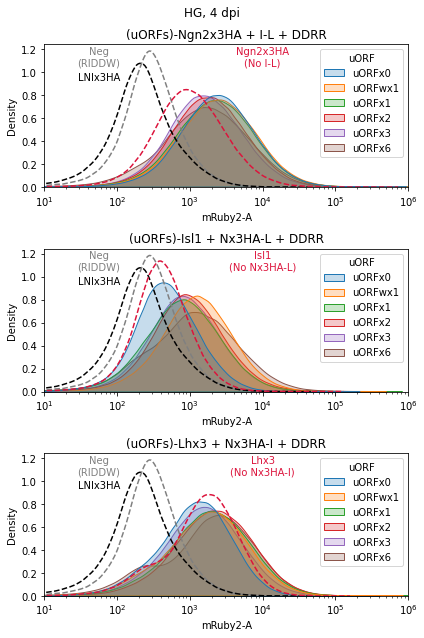

In [18]:
# Plot mRuby2-A
x = 'mRuby2-A'
hue = 'uORF'
uORF_list = ['uORFx0', 'uORFwx1', 'uORFx1', 'uORFx2', 'uORFx3', 'uORFx6']
cond_list = ['Ngn2x3HA', 'Isl1', 'Lhx3']
const_list = ['I-L', 'Nx3HA-L', 'Nx3HA-I']

fig, ax = plt.subplots(len(cond_list), 1, figsize=(6, 9))
for (i, cond) in enumerate(cond_list):

    sns.kdeplot(data=data_4dpi.loc[data_4dpi.cond == cond],
        ax=ax[i], x=x, hue=hue,
        hue_order=uORF_list,
        common_norm=False, log_scale=(True, False),
        fill=True)
    
    # Title
    ax[i].set_title('(uORFs)-{} + {} + DDRR'.format(cond, const_list[i]))

    # Plot neg ctrl
    sns.kdeplot(data=data_4dpi_ctrl[(data_4dpi_ctrl['cond'] == 'Ctrl-RIDDW')], x=x, common_norm=False,
                ax=ax[i], log_scale=(True, False), color='grey', fill=False, linestyle='--')
    ax[i].annotate('Neg\n(RIDDW)', (0.15, 0.85), color='grey', xycoords='axes fraction', ha='center')

    # Plot LNIx3HA reprogram ctrl
    sns.kdeplot(data=data_4dpi_ctrl[(data_4dpi_ctrl['cond'] == 'Ctrl-LNIx3HA')], x=x, common_norm=False,
                ax=ax[i], log_scale=(True, False), color='black', fill=False, linestyle='--')
    ax[i].annotate('LNIx3HA', (0.15, 0.75), color='black', xycoords='axes fraction', ha='center')

    # Plot no const. ctrl
    sns.kdeplot(data=data_4dpi[(data_4dpi['cond'] ==  cond) & (data_4dpi['const'] ==  'None')], x=x, common_norm=False,
                ax=ax[i], log_scale=(True, False), color='crimson', fill=False, linestyle='--')
    ax[i].annotate('{}\n(No {})'.format(cond, const_list[i]), (0.6, 0.85), color='crimson', xycoords='axes fraction', ha='center')

# Adjust limits
mRuby2_lim = (10, 1*10**6)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(mRuby2_lim)

# Misc plotting stuff
plt.suptitle('HG, 4 dpi')
fig.tight_layout()  # Helps improve white spacing

## Look at mRuby2 in HyperP vs. non-hyperP at 4 dpi

### Calc for hyperP and non-hyperP mRuby2

In [19]:
# Integrate mRuby2 gmean for hyper and non-hyperP at 4 dpi into single df
x = 'mRuby2-A'

group = ['cond', 'const', 'DDRR_cat', 'uORF', 'rep']
data_4dpi_gmean_reps = data_4dpi.groupby(
        [*group, 'well', 'CTV_cat'])[x].apply(scipy.stats.gmean).reset_index(name=x+' (gmean)')
        
# log10 transform data
data_4dpi.loc[:, 'log({})'.format(x)] = np.log10(data_4dpi[x])
data_4dpi_gmean_reps.loc[:, 'log({})'.format(x+' (gmean)')] = np.log10(data_4dpi_gmean_reps[x+' (gmean)'])

# Collapse to bio reps
data_4dpi_gmean = data_4dpi_gmean_reps.groupby([*group, 'CTV_cat']).mean().reset_index()

/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Plot for uORFx0 (baseline) for each TF

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Isl1_non-CTV-low vs. Isl1_CTV-low: t-test for independent samples from scipy with greater 1-way (mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample), P_val:8.801e-04 Stat=5.341e+00
Ngn2x3HA_non-CTV-low vs. Ngn2x3HA_CTV-low: t-test for independent samples from scipy with greater 1-way (mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample), P_val:3.242e-02 Stat=2.257e+00
Lhx3_non-CTV-low vs. Lhx3_CTV-low: t-test for independent samples from scipy with greater 1-way (mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample), P_val:3.983e-04 Stat=6.222e+00


/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


Text(0.5, 1.0, '4 dpi')

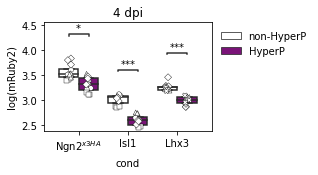

In [20]:
# Plotting params
x = 'cond'
y = 'mRuby2-A'
hue = 'CTV_cat'

# Restrict to just baseline condition (no uORF) with + DDRR
DDRR_cat = True
uORF = 'uORFx0'

order = ['Ngn2x3HA', 'Isl1', 'Lhx3']
hue_order = ['non-CTV-low', 'CTV-low']

# palette = {'HA (Ngn2$^{x3HA}$)': '#068B89', 'Isl1': '#ED8163', 'Lhx3': '#498BC7'}

colormap = {'CTV-low': '#8b0288',
            'non-CTV-low': 'white'}
marker_list = ['o', 's', '^', 'D', 'P', 'X']

fig, ax = plt.subplots(1, 1, figsize=(3, 2))

# Restrict to just + DDRR
df = data_4dpi.loc[(data_4dpi.DDRR_cat == DDRR_cat) & (data_4dpi.uORF == uORF)]
df_gmean_reps = data_4dpi_gmean_reps.loc[(data_4dpi_gmean_reps.DDRR_cat == DDRR_cat) & (data_4dpi_gmean_reps.uORF == uORF)]
df_gmean = data_4dpi_gmean.loc[(data_4dpi_gmean.DDRR_cat == DDRR_cat) & (data_4dpi_gmean.uORF == uORF)]

# Plot log10 transformed -> well geometric means
for (i, rep) in enumerate(df_gmean_reps.rep.unique()):
    sns.stripplot(
        ax=ax, data=df_gmean_reps[df_gmean_reps.rep == rep],
        x=x, y='log({})'.format(y+' (gmean)'), hue=hue,
        order=order, hue_order=hue_order,
        dodge=True, marker=marker_list[i],
        palette={'CTV-low': 'white', 'non-CTV-low': 'white'}, size=5,
        edgecolor='black', linewidth=0.4,)

# Plot as box
sns.boxplot(ax=ax,
    data=df_gmean_reps, 
    y = 'log({})'.format(y+' (gmean)'), #y='log({})'.format(y),
    x=x, hue=hue,
    order=order, hue_order=hue_order, 
    width=0.8, palette={'CTV-low': '#8b0288', 'non-CTV-low': 'white'}, whis=0, showfliers=False)

# Add in stats
# Pairs for stats comp
pairs = [((cond, 'CTV-low'), (cond, 'non-CTV-low')) for cond in order]
annot = Annotator(ax=ax,
    data=df_gmean, pairs=pairs,
    x=x, y='log({})'.format(y+' (gmean)'), 
    hue=hue, order=order, hue_order=hue_order)
annot.configure(test=ttest_ind_greater, text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate(line_offset_to_group=0.3)

# Adjust labels
lmap = {'CTV-low':'HyperP', 'non-CTV-low':'non-HyperP'}
h,l = ax.get_legend_handles_labels()
sns.move_legend(ax, handles=h[-len(hue_order):], labels=[lmap[i] for i in l[-len(hue_order):]],
    title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)
ax.set_xticklabels(['Ngn2$^{x3HA}$', 'Isl1', 'Lhx3'])
ax.yaxis.set_label_text('log(mRuby2)')
plt.title('4 dpi')

Non-log box plot

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Isl1_non-CTV-low vs. Isl1_CTV-low: t-test for independent samples from scipy with greater 1-way (mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample), P_val:8.801e-04 Stat=5.341e+00
Ngn2x3HA_non-CTV-low vs. Ngn2x3HA_CTV-low: t-test for independent samples from scipy with greater 1-way (mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample), P_val:3.242e-02 Stat=2.257e+00
Lhx3_non-CTV-low vs. Lhx3_CTV-low: t-test for independent samples from scipy with greater 1-way (mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample), P_val:3.983e-04 Stat=6.222e+00


/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


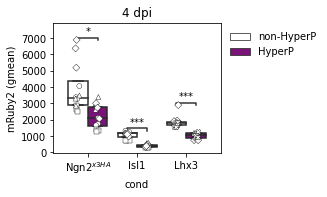

In [21]:
# Plotting params
x = 'cond'
y = 'mRuby2-A'
hue = 'CTV_cat'

# Restrict to just baseline condition (no uORF) with + DDRR
DDRR_cat = True
uORF = 'uORFx0'

order = ['Ngn2x3HA', 'Isl1', 'Lhx3']
hue_order = ['non-CTV-low', 'CTV-low']

# palette = {'HA (Ngn2$^{x3HA}$)': '#068B89', 'Isl1': '#ED8163', 'Lhx3': '#498BC7'}

colormap = {'CTV-low': '#8b0288',
            'non-CTV-low': 'white'}
marker_list = ['o', 's', '^', 'D', 'P', 'X']

fig, ax = plt.subplots(1, 1, figsize=(3, 2.4))

# Restrict to just + DDRR
df = data_4dpi.loc[(data_4dpi.DDRR_cat == DDRR_cat) & (data_4dpi.uORF == uORF)]
df_gmean_reps = data_4dpi_gmean_reps.loc[(data_4dpi_gmean_reps.DDRR_cat == DDRR_cat) & (data_4dpi_gmean_reps.uORF == uORF)]
df_gmean = data_4dpi_gmean.loc[(data_4dpi_gmean.DDRR_cat == DDRR_cat) & (data_4dpi_gmean.uORF == uORF)]

# Plot log10 transformed -> well geometric means
for (i, rep) in enumerate(df_gmean_reps.rep.unique()):
    sns.stripplot(
        ax=ax, data=df_gmean_reps[df_gmean_reps.rep == rep],
        x=x, y=(y+' (gmean)'), hue=hue,
        order=order, hue_order=hue_order,
        dodge=True, marker=marker_list[i],
        palette={'CTV-low': 'white', 'non-CTV-low': 'white'}, size=5,
        edgecolor='black', linewidth=0.4,)

# Plot as box
sns.boxplot(ax=ax,
    data=df_gmean_reps, 
    y = (y+' (gmean)'), #y='log({})'.format(y),
    x=x, hue=hue,
    order=order, hue_order=hue_order, 
    width=0.8, palette={'CTV-low': '#8b0288', 'non-CTV-low': 'white'}, whis=0, showfliers=False)

# Add in stats
# Pairs for stats comp
pairs = [((cond, 'CTV-low'), (cond, 'non-CTV-low')) for cond in order]
annot = Annotator(ax=ax,
    data=df_gmean, pairs=pairs,
    x=x, y='log({})'.format(y+' (gmean)'), 
    hue=hue, order=order, hue_order=hue_order)
annot.configure(test=ttest_ind_greater, text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate(line_offset_to_group=0)

# Adjust labels
lmap = {'CTV-low':'HyperP', 'non-CTV-low':'non-HyperP'}
h,l = ax.get_legend_handles_labels()
sns.move_legend(ax, handles=h[-len(hue_order):], labels=[lmap[i] for i in l[-len(hue_order):]],
    title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)
ax.set_xticklabels(['Ngn2$^{x3HA}$', 'Isl1', 'Lhx3'])
ax.yaxis.set_label_text('mRuby2 (gmean)')
ax.set_yticks(np.arange(0,8*10**3, 10**3))
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.title('4 dpi')

plt.savefig(figpath + '4dpi_mRuby2-hyperPvsnonHyperP_box-nonlog.svg', bbox_inches='tight')

# Look at 14 dpi data

## Load 14 dpi data

In [22]:
# Directories
base_datadir = rd.datadir/'2023.03.02_HG_NIL-titrate_14dpi'

# List of data folder names
dir_list = ['2023.03.02_HG_NIL-titrate_1_14dpi', '2023.03.02_HG_NIL-titrate_2_14dpi', '2023.04.08_HG_NIL-titrate_3_14dpi', '2023.04.08_HG_NIL-titrate_4_14dpi',
            '2023.11.26_HG_NIL-titrate_7_14dpi',  '2023.11.26_HG_NIL-titrate_8_14dpi']

# List of ctrls and samples
ctrl_list = ['Ctrl-puro-2A-mRuby2', 'Ctrl-LNIx3HA']
cond_list = ['Ngn2x3HA', 'Isl1', 'Lhx3', 'No Ngn2x3HA', 'No Isl1', 'No Lhx3']

# Store all data in list of dfs which will be converted to df at end
data_14dpi_all = list()
data_14dpi_mRuby2_all = list()

# get all csvs for each dir
for (j, dir_name) in enumerate(dir_list):
    
    # Load as df and note header is on 0th row
    df = rd.flow.load_csv_with_metadata(
        base_datadir/dir_name/'export_singlets_NIL-titrate', base_datadir/'well_metadata.yaml')

    df['rep'] = j
    data_14dpi_all.append(df)

    # Load as df and note header is on 0th row
    df_mRuby2 = rd.flow.load_csv_with_metadata(
        base_datadir/dir_name/'export_singlets_NIL-titrate_mRuby2', base_datadir/'well_metadata.yaml')

    df_mRuby2['rep'] = j
    data_14dpi_mRuby2_all.append(df_mRuby2)
    
# Convert list of dfs into single df
data_14dpi_all = pd.concat(data_14dpi_all, ignore_index=True)
data_14dpi_mRuby2_all = pd.concat(data_14dpi_mRuby2_all, ignore_index=True)

# Remove negative data
data_14dpi_all = data_14dpi_all.loc[
    (data_14dpi_all['eGFP-A'] > 0) &
    (data_14dpi_all['mRuby2-A'] > 0)
]
data_14dpi_mRuby2_all = data_14dpi_mRuby2_all.loc[
    (data_14dpi_mRuby2_all['eGFP-A'] > 0) &
    (data_14dpi_mRuby2_all['mRuby2-A'] > 0)
]

# Replace missing data with NA string
data_14dpi_all = data_14dpi_all.fillna("NA")
data_14dpi_mRuby2_all = data_14dpi_mRuby2_all.fillna("NA")

# Separate out ctrl and sample data
data_14dpi_ctrl = data_14dpi_all[ data_14dpi_all['cond'].isin(ctrl_list) ]
data_14dpi = data_14dpi_all[ data_14dpi_all['cond'].isin(cond_list) ]
data_14dpi_mRuby2_ctrl = data_14dpi_mRuby2_all[ data_14dpi_mRuby2_all['cond'].isin(ctrl_list) ]
data_14dpi_mRuby2 = data_14dpi_mRuby2_all[ data_14dpi_mRuby2_all['cond'].isin(cond_list) ]

## Look at iMN at 14 dpi

### Categorize 14 dpi iMN

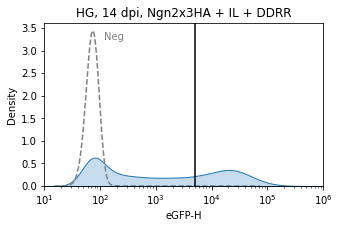

In [23]:
# Threshold for iMNs
eGFP_H_thresh = 5*10**3

# Downsample to 100,000 cells from NIL
small_data = data_14dpi[(data_14dpi['cond'] == 'Ngn2x3HA')].sample(n=10**5, random_state=1)

# Plot eGFP-H
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
x = 'eGFP-H'
sns.kdeplot(data=small_data.loc[(small_data['uORF'] == 'uORFx0')],
        ax=ax, x=x,
        common_norm=False, log_scale=(True, False),
        fill=True)

# Plot neg ctrl
sns.kdeplot(data=data_14dpi_ctrl[(data_14dpi_ctrl['cond'] == 'Ctrl-puro-2A-mRuby2')],
            x=x, common_norm=False,
            ax=ax, log_scale=(True, False), color='grey', fill=False, linestyle='--')
ax.annotate('Neg', (0.25, 0.9), color='grey', xycoords='axes fraction', ha='center')

# Plot threshold
ax.axvline(eGFP_H_thresh, 0, 1, color='black')

# Title
plt.title('HG, 14 dpi, Ngn2x3HA + IL + DDRR')
# Adjust limits
eGFP_lim = (10, 1*10**6)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(eGFP_lim)

In [24]:
# Categorize iMNs based on eGFP_thresh
data_14dpi.loc[:, 'eGFP_cat'] = 'fib'
data_14dpi.loc[(data_14dpi['eGFP-H'] > eGFP_H_thresh), 'eGFP_cat'] = 'iMN'

# Get total counts and percent of GFP-H+
group = ['cond', 'const', 'DDRR_cat', 'uORF', 'rep']
count_df_reps = data_14dpi.groupby([*group, 'well', 'eGFP_cat'])[
    'FSC-A'].count().unstack(fill_value=0).stack().rename('count') # Puts 0 if no GFP-H+ rather than dropping row
percent_df_reps = (count_df_reps*100/count_df_reps.groupby([*group, 'well']).transform('sum')).reset_index(name='percent')

# Get iMN yield per condition
seedNum = 10**4 # Seeded 10k MEFs/96-well
data_iMN_yield_reps = (count_df_reps*100/seedNum).reset_index(name='yield')

# Extract just the iMNs
data_iMN_yield_reps = data_iMN_yield_reps.loc[(data_iMN_yield_reps['eGFP_cat'] == 'iMN')]
data_iMN_percent_reps = percent_df_reps.loc[(percent_df_reps['eGFP_cat'] == 'iMN')]

# Collapse to bio reps
data_iMN_yield = data_iMN_yield_reps.groupby([*group]).mean().reset_index()
data_iMN_percent = data_iMN_percent_reps.groupby([*group]).mean().reset_index()

/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


### Look at yield

/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A v

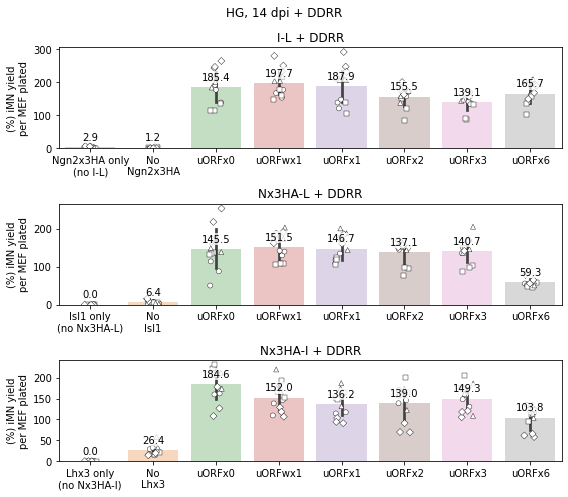

In [25]:
# General plotting params
x = 'uORF'
y = 'yield'
uORF_list = ['uORFx0', 'uORFwx1', 'uORFx1', 'uORFx2', 'uORFx3', 'uORFx6']
cond_list = ['Ngn2x3HA', 'Isl1', 'Lhx3']
const_list = ['I-L', 'Nx3HA-L', 'Nx3HA-I']
units = 'rep'
marker_list = ['o', 's', '^', 'D', 'P', 'X']

# Plot iMN percent of all cells
fig, ax = plt.subplots(len(cond_list), 1, figsize=(8,7))
for (i, cond) in enumerate(cond_list):

    # Make new df with no const expression ctrl
    noConstData = data_iMN_yield_reps[(data_iMN_yield_reps['cond'] ==  cond) & (data_iMN_yield_reps['const'] ==  'None')]
    noConstData_uORFrename = '{} only\n(no {})'.format(cond, const_list[i])
    noConstData.uORF = noConstData_uORFrename
    # Make new df with only const expression ctrl
    onlyConstData = data_iMN_yield_reps[(data_iMN_yield_reps['cond'] ==  'No {}'.format(cond)) & (data_iMN_yield_reps['const'] ==  const_list[i])]
    constData_uORFrename = 'No\n{}'.format(cond)
    onlyConstData.uORF = constData_uORFrename
    onlyConstData.cond = cond

    # Recombine df's
    df = pd.concat([noConstData, onlyConstData,
                    data_iMN_yield_reps.loc[(data_iMN_yield_reps.cond == cond) & (data_iMN_yield_reps.const == const_list[i])]], ignore_index=True)
    order = [noConstData_uORFrename, constData_uORFrename, *uORF_list]

    # Plot
    sns.barplot(ax=ax[i], data=df,
                x=x, y=y,
                order=order, units=units,
                alpha=0.3)
    
    # Plot bio tech reps
    for (j, rep) in enumerate(df.rep.unique()):
        sns.stripplot(
            ax=ax[i], data=df[df.rep == rep],
            x=x, y=y,
            order=order,
            dodge=True, marker=marker_list[j],
            color='white', size=5,
            edgecolor='black', linewidth=0.4,)
     
    # Title
    ax[i].set_title('{} + DDRR'.format(const_list[i]))
    

# Formatting
for sub_ax in plt.gcf().get_axes():
    # Change x axis
    sub_ax.xaxis.set_label_text('')
    # Change y axis
    sub_ax.yaxis.set_label_text('(%) iMN yield\nper MEF plated')
    # sub_ax.set_yticks(np.arange(0, 160, 50))
    # Add barplot labels
    for i in sub_ax.containers:
        bar_labels = sub_ax.bar_label(i, fmt='%0.1f', padding=5)
        for label in bar_labels:
            label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))    

# Format
plt.suptitle('HG, 14 dpi + DDRR')
fig.tight_layout()  # Helps improve white spacing

### Look at purity

/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A v

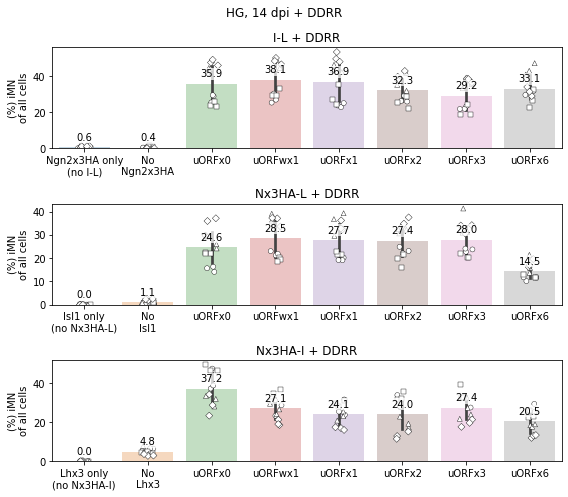

In [26]:
# General plotting params
x = 'uORF'
y = 'percent'
uORF_list = ['uORFx0', 'uORFwx1', 'uORFx1', 'uORFx2', 'uORFx3', 'uORFx6']
cond_list = ['Ngn2x3HA', 'Isl1', 'Lhx3']
const_list = ['I-L', 'Nx3HA-L', 'Nx3HA-I']
units = 'rep'
marker_list = ['o', 's', '^', 'D', 'P', 'X']

# Plot iMN percent of all cells
fig, ax = plt.subplots(len(cond_list), 1, figsize=(8,7))
for (i, cond) in enumerate(cond_list):

    # Make new df with no const expression ctrl
    noConstData = data_iMN_percent_reps[(data_iMN_percent_reps['cond'] ==  cond) & (data_iMN_percent_reps['const'] ==  'None')]
    noConstData_uORFrename = '{} only\n(no {})'.format(cond, const_list[i])
    noConstData.uORF = noConstData_uORFrename
    # Make new df with only const expression ctrl
    onlyConstData = data_iMN_percent_reps[(data_iMN_percent_reps['cond'] ==  'No {}'.format(cond)) & (data_iMN_percent_reps['const'] ==  const_list[i])]
    constData_uORFrename = 'No\n{}'.format(cond)
    onlyConstData.uORF = constData_uORFrename
    onlyConstData.cond = cond

    # Recombine df's
    df = pd.concat([noConstData, onlyConstData,
                    data_iMN_percent_reps.loc[(data_iMN_percent_reps.cond == cond) & (data_iMN_percent_reps.const == const_list[i])]], ignore_index=True)
    order = [noConstData_uORFrename, constData_uORFrename, *uORF_list]

    # Plot
    sns.barplot(ax=ax[i], data=df,
                x=x, y=y,
                order=order, units=units,
                alpha=0.3)
    # Plot bio tech reps
    for (j, rep) in enumerate(df.rep.unique()):
        sns.stripplot(
            ax=ax[i], data=df[df.rep == rep],
            x=x, y=y,
            order=order,
            dodge=True, marker=marker_list[j],
            color='white', size=5,
            edgecolor='black', linewidth=0.4,)
    
    # Title
    ax[i].set_title('{} + DDRR'.format(const_list[i]))
    

# Formatting
for sub_ax in plt.gcf().get_axes():
    # Change x axis
    sub_ax.xaxis.set_label_text('')
    # Change y axis
    sub_ax.yaxis.set_label_text('(%) iMN\nof all cells')
    # sub_ax.set_yticks(np.arange(0, 160, 50))
    # Add barplot labels
    for i in sub_ax.containers:
        bar_labels = sub_ax.bar_label(i, fmt='%0.1f', padding=5)
        for label in bar_labels:
            label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))    

# Format
plt.suptitle('HG, 14 dpi + DDRR')
fig.tight_layout()  # Helps improve white spacing

## Look at mRuby2 at 14 dpi

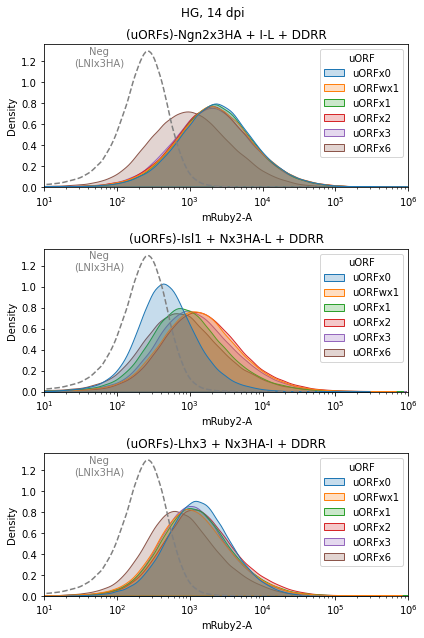

In [27]:
# Plot mRuby2-A
x = 'mRuby2-A'
hue = 'uORF'
uORF_list = ['uORFx0', 'uORFwx1', 'uORFx1', 'uORFx2', 'uORFx3', 'uORFx6']
cond_list = ['Ngn2x3HA', 'Isl1', 'Lhx3']
const_list = ['I-L', 'Nx3HA-L', 'Nx3HA-I']
rep = 3

fig, ax = plt.subplots(len(cond_list), 1, figsize=(6, 9))
for (i, cond) in enumerate(cond_list):

    sns.kdeplot(data=data_14dpi.loc[(data_14dpi.cond == cond) & (data_14dpi.rep == rep)],
        ax=ax[i], x=x, hue=hue,
        hue_order=uORF_list,
        common_norm=False, log_scale=(True, False),
        fill=True)
    
    # Title
    ax[i].set_title('(uORFs)-{} + {} + DDRR'.format(cond, const_list[i]))

    # Plot neg ctrl
    sns.kdeplot(data=data_14dpi_ctrl[(data_14dpi_ctrl['cond'] == 'Ctrl-LNIx3HA') & (data_14dpi_ctrl.rep == rep)], x=x, common_norm=False,
                ax=ax[i], log_scale=(True, False), color='grey', fill=False, linestyle='--')
    ax[i].annotate('Neg\n(LNIx3HA)', (0.15, 0.85), color='grey', xycoords='axes fraction', ha='center')

# Adjust limits
mRuby2_lim = (10, 1*10**6)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(mRuby2_lim)

# Misc plotting stuff
plt.suptitle('HG, 14 dpi')
fig.tight_layout()  # Helps improve white spacing

# Plot 4 dpi data against 14 dpi data

In [29]:
# Categorize iMNs based on eGFP_thresh
data_14dpi_mRuby2.loc[:, 'eGFP_cat'] = 'fib'
data_14dpi_mRuby2.loc[(data_14dpi_mRuby2['eGFP-H'] > eGFP_H_thresh), 'eGFP_cat'] = 'iMN'

# Get total counts and percent of GFP-H+
group = ['cond', 'const', 'DDRR_cat', 'uORF', 'rep']
count_df_reps = data_14dpi_mRuby2.groupby([*group, 'well', 'eGFP_cat'])[
    'FSC-A'].count().unstack(fill_value=0).stack().rename('count') # Puts 0 if no GFP-H+ rather than dropping row
percent_df_reps = (count_df_reps*100/count_df_reps.groupby([*group, 'well']).transform('sum')).reset_index(name='efficiency')

# Extract just the iMNs
data_14dpi_mRuby2_iMN_efficiency_reps = percent_df_reps.loc[(percent_df_reps['eGFP_cat'] == 'iMN')]

# Collapse to bio reps
data_14dpi_mRuby2_iMN_efficiency = data_14dpi_mRuby2_iMN_efficiency_reps.groupby([*group]).mean().reset_index()

/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [30]:
# Get mRuby2+ on 14 dpi
group = ['cond', 'const', 'DDRR_cat', 'uORF', 'rep']
data_14dpi_mRuby2_count_reps = data_14dpi_mRuby2.groupby([*group, 'well'])[
    'FSC-A'].count().rename('count').reset_index() # Puts 0 if no GFP-H+ rather than dropping row
# Collapse to bio reps
data_14dpi_mRuby2_count = data_14dpi_mRuby2_count_reps.groupby(group).mean().reset_index()

In [31]:
# Calculate count populations using this grouping
grouping = ['cond', 'const', 'DDRR_cat', 'uORF', 'rep']
data_4dpi_mRuby2_count_reps = data_4dpi_mRuby2.groupby([*grouping, 'well'])[
    'FSC-A'].count().rename('count').reset_index() # Puts 0 if none rather than dropping row

data_4dpi_mRuby2_count = data_4dpi_mRuby2_count_reps.groupby(grouping).mean().reset_index()

In [32]:
# Copy dataframe of hyperP/non-hyperP 4 dpi cells that will integrate with the 14 dpi data
data_both_reps = data_4dpi_gmean_reps.copy()

# Rename some columns to be clear it's 4 dpi
data_both_reps.rename(
    columns={"mRuby2-A (gmean)": "4dpi mRuby2-A (gmean)",
             "log(mRuby2-A (gmean))": "4dpi log(mRuby2-A (gmean))"}, 
    inplace=True
)

# Integrate iMN yield and percent into 4 dpi data
for index, row in data_both_reps.iterrows():

    # Get avg 4 dpi mRuby2+ count
    mRuby2_4_count = data_4dpi_mRuby2_count_reps.loc[
        (data_4dpi_mRuby2_count_reps['rep']==row.rep) & 
        (data_4dpi_mRuby2_count_reps['cond']==row.cond) &
        (data_4dpi_mRuby2_count_reps['const']==row.const) &
        (data_4dpi_mRuby2_count_reps['DDRR_cat']==row.DDRR_cat) &
        (data_4dpi_mRuby2_count_reps['uORF']==row.uORF) & 
        (data_4dpi_mRuby2_count_reps['well']==row.well)
    ]['count']

    # Get avg 14 dpi mRuby2+ count
    mRuby2_14_count = data_14dpi_mRuby2_count_reps.loc[
        (data_14dpi_mRuby2_count_reps['rep']==row.rep) & 
        (data_14dpi_mRuby2_count_reps['cond']==row.cond) &
        (data_14dpi_mRuby2_count_reps['const']==row.const) &
        (data_14dpi_mRuby2_count_reps['DDRR_cat']==row.DDRR_cat) &
        (data_14dpi_mRuby2_count_reps['uORF']==row.uORF) & 
        (data_14dpi_mRuby2_count_reps['well']==row.well)
    ]['count']

    # Get iMN yield
    iMN_yield = data_iMN_yield_reps.loc[
        (data_iMN_yield_reps['rep']==row.rep) & 
        (data_iMN_yield_reps['cond']==row.cond) &
        (data_iMN_yield_reps['const']==row.const) &
        (data_iMN_yield_reps['DDRR_cat']==row.DDRR_cat) &
        (data_iMN_yield_reps['uORF']==row.uORF) & 
        (data_iMN_yield_reps['well']==row.well)
        ]['yield']
    # Get iMN percent
    iMN_percent = data_iMN_percent_reps.loc[
        (data_iMN_percent_reps['rep']==row.rep) & 
        (data_iMN_percent_reps['cond']==row.cond) &
        (data_iMN_percent_reps['const']==row.const) &
        (data_iMN_percent_reps['DDRR_cat']==row.DDRR_cat) &
        (data_iMN_percent_reps['uORF']==row.uORF) & 
        (data_iMN_percent_reps['well']==row.well)
        ]['percent']
    # Get iMN efficiency
    iMN_efficiency = data_14dpi_mRuby2_iMN_efficiency_reps.loc[
        (data_14dpi_mRuby2_iMN_efficiency_reps['rep']==row.rep) & 
        (data_14dpi_mRuby2_iMN_efficiency_reps['cond']==row.cond) &
        (data_14dpi_mRuby2_iMN_efficiency_reps['const']==row.const) &
        (data_14dpi_mRuby2_iMN_efficiency_reps['DDRR_cat']==row.DDRR_cat) &
        (data_14dpi_mRuby2_iMN_efficiency_reps['uORF']==row.uORF) & 
        (data_14dpi_mRuby2_iMN_efficiency_reps['well']==row.well)
    ]['efficiency']

    # Get iMN yield relative to mRuby2+
    iMN_yield_rel_4 = float(iMN_yield)/float(mRuby2_4_count)*seedNum
    iMN_yield_rel_14 = float(iMN_yield)/float(mRuby2_14_count)*seedNum

    # Integrate in
    # If empty (i.e. wells not collected), skip it
    if len(iMN_yield) == 0:
        continue
    data_both_reps.loc[index, 'iMN yield'] = float(iMN_yield)
    data_both_reps.loc[index, 'iMN percent'] = float(iMN_percent)
    data_both_reps.loc[index, 'iMN efficiency'] = float(iMN_efficiency)
    data_both_reps.loc[index, 'iMN yield rel to mRuby2+ (4 dpi)'] = float(iMN_yield_rel_4)
    data_both_reps.loc[index, 'iMN yield rel to mRuby2+ (14 dpi)'] = float(iMN_yield_rel_14)
    

### Yield

/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A v

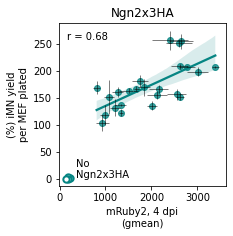

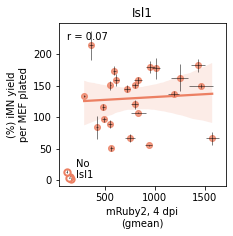

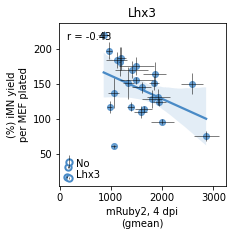

In [34]:
# General plotting params
x = '4dpi mRuby2-A (gmean)'
y = 'iMN yield'
hue = 'uORF'

uORF_list = ['uORFx0', 'uORFwx1', 'uORFx1', 'uORFx2', 'uORFx3', 'uORFx6']
cond_list = ['Ngn2x3HA', 'Isl1', 'Lhx3']
const_list = ['I-L', 'Nx3HA-L', 'Nx3HA-I']
color_list = ['#068583', '#ec8063', '#498ac6']

# Plot eGFP percent of all cells vs. mRuby2
for (i, cond) in enumerate(cond_list):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    # cond = cond_list[i]
    color = color_list[i]

    # Make new df with no const expression ctrl
    noConstData = data_both_reps[(data_both_reps['cond'] ==  cond) & (data_both_reps['const'] ==  'None')]
    noConstData_uORFrename = '{} only\n(no {})'.format(cond, const_list[i])
    noConstData.uORF = noConstData_uORFrename
    # Make new df with only data_both expression ctrl
    onlyConstData = data_both_reps[(data_both_reps['cond'] ==  'No {}'.format(cond)) & (data_both_reps['const'] ==  const_list[i])]
    constData_uORFrename = 'No\n{}'.format(cond)
    onlyConstData.uORF = constData_uORFrename
    onlyConstData.cond = cond

    # Just get current cond data
    df = pd.concat(
        [data_both_reps.loc[(data_both_reps.cond == cond) & (data_both_reps.const == const_list[i])]],
        ignore_index=True)

    # Calc mean and SEM for each cond
    grouping = ['uORF', 'rep', 'CTV_cat']
    data_both_mean = df.groupby(grouping).mean(numeric_only=True).reset_index()
    data_both_SEM = df.groupby(grouping).sem().reset_index()
    data_noConstData_mean = noConstData.groupby(grouping).mean(numeric_only=True).reset_index()
    data_noConstData_SEM = noConstData.groupby(grouping).sem().reset_index()
    data_onlyConstData_mean = onlyConstData.groupby(grouping).mean(numeric_only=True).reset_index()
    data_onlyConstData_SEM = onlyConstData.groupby(grouping).sem().reset_index()

    # Split into hyperP and non
    data_both_mean_hyperP = data_both_mean.loc[data_both_mean.CTV_cat == 'CTV-low']
    data_both_SEM_hyperP = data_both_SEM.loc[data_both_SEM.CTV_cat == 'CTV-low']
    data_noConstData_mean_hyperP = data_noConstData_mean.loc[data_noConstData_mean.CTV_cat == 'CTV-low']
    data_noConstData_SEM_hyperP = data_noConstData_SEM.loc[data_noConstData_SEM.CTV_cat == 'CTV-low']
    data_onlyConstData_mean_hyperP = data_onlyConstData_mean.loc[data_onlyConstData_mean.CTV_cat == 'CTV-low']
    data_onlyConstData_SEM_hyperP = data_onlyConstData_SEM.loc[data_onlyConstData_SEM.CTV_cat == 'CTV-low']
    data_both_mean_nonhyperP = data_both_mean.loc[data_both_mean.CTV_cat == 'non-CTV-low']
    data_both_SEM_nonhyperP = data_both_SEM.loc[data_both_SEM.CTV_cat == 'non-CTV-low']
    data_noConstData_mean_nonhyperP = data_noConstData_mean.loc[data_noConstData_mean.CTV_cat == 'non-CTV-low']
    data_noConstData_SEM_nonhyperP = data_noConstData_SEM.loc[data_noConstData_SEM.CTV_cat == 'non-CTV-low']
    data_onlyConstData_mean_nonhyperP = data_onlyConstData_mean.loc[data_onlyConstData_mean.CTV_cat == 'non-CTV-low']
    data_onlyConstData_SEM_nonhyperP = data_onlyConstData_SEM.loc[data_onlyConstData_SEM.CTV_cat == 'non-CTV-low']

    # Plot main datta
    sns.regplot(ax=ax, data=data_both_mean_hyperP, x=x, y=y, color=color)
    ax.errorbar(x=data_both_mean_hyperP[x], y=data_both_mean_hyperP[y],
            xerr=data_both_SEM_hyperP[x], yerr=data_both_SEM_hyperP[y],
            color='None', ecolor='black', elinewidth=0.5)

    # Plot ctrls
    ax.text(.1, 0.05, constData_uORFrename, transform=ax.transAxes)
    sns.scatterplot(
        ax=ax, data=data_onlyConstData_mean_hyperP, x=x, y=y, 
        color='white', edgecolor=color, s=40, linewidth=2)
    ax.errorbar(
        x=data_onlyConstData_mean_hyperP[x], y=data_onlyConstData_mean_hyperP[y],
        xerr=data_onlyConstData_SEM_hyperP[x], yerr=data_onlyConstData_SEM_hyperP[y],
        color='None', ecolor='black', elinewidth=0.5)

    # Add in Pearson r linear correlation
    r, p = scipy.stats.pearsonr(x=data_both_mean_hyperP[x], y=data_both_mean_hyperP[y])
    ax.text(.05, 0.9, 'r = {:.2f}'.format(r),transform=ax.transAxes)

    # Format
    ax.set_title(cond)
    ax.xaxis.set_label_text('mRuby2, 4 dpi\n(gmean)')
    ax.yaxis.set_label_text('(%) iMN yield\nper MEF plated')
    
    # plt.savefig(figpath + '14dpi_iMNyield_v_4dpi-mRuby2-hyperP_{}_reps_labels.svg'.format(cond), bbox_inches='tight')

#### Both on same graph

/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A v

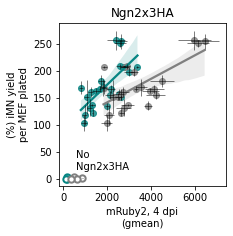

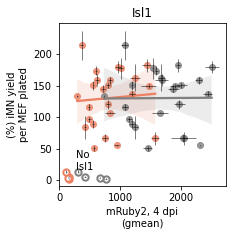

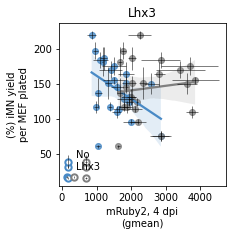

In [35]:
# General plotting params
x = '4dpi mRuby2-A (gmean)'
y = 'iMN yield'
hue = 'uORF'

uORF_list = ['uORFx0', 'uORFwx1', 'uORFx1', 'uORFx2', 'uORFx3', 'uORFx6']
cond_list = ['Ngn2x3HA', 'Isl1', 'Lhx3']
const_list = ['I-L', 'Nx3HA-L', 'Nx3HA-I']
color_list = ['#068583', '#ec8063', '#498ac6']

# Plot eGFP percent of all cells vs. mRuby2
for (i, cond) in enumerate(cond_list):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    # cond = cond_list[i]
    color = color_list[i]

    # Make new df with no const expression ctrl
    noConstData = data_both_reps[(data_both_reps['cond'] ==  cond) & (data_both_reps['const'] ==  'None')]
    noConstData_uORFrename = '{} only\n(no {})'.format(cond, const_list[i])
    noConstData.uORF = noConstData_uORFrename
    # Make new df with only data_both expression ctrl
    onlyConstData = data_both_reps[(data_both_reps['cond'] ==  'No {}'.format(cond)) & (data_both_reps['const'] ==  const_list[i])]
    constData_uORFrename = 'No\n{}'.format(cond)
    onlyConstData.uORF = constData_uORFrename
    onlyConstData.cond = cond

    # Just get current cond data
    df = pd.concat(
        [data_both_reps.loc[(data_both_reps.cond == cond) & (data_both_reps.const == const_list[i])]],
        ignore_index=True)

    # Calc mean and SEM for each cond
    grouping = ['uORF', 'rep', 'CTV_cat']
    data_both_mean = df.groupby(grouping).mean(numeric_only=True).reset_index()
    data_both_SEM = df.groupby(grouping).sem().reset_index()
    data_noConstData_mean = noConstData.groupby(grouping).mean(numeric_only=True).reset_index()
    data_noConstData_SEM = noConstData.groupby(grouping).sem().reset_index()
    data_onlyConstData_mean = onlyConstData.groupby(grouping).mean(numeric_only=True).reset_index()
    data_onlyConstData_SEM = onlyConstData.groupby(grouping).sem().reset_index()

    # Split into hyperP and non
    data_both_mean_hyperP = data_both_mean.loc[data_both_mean.CTV_cat == 'CTV-low']
    data_both_SEM_hyperP = data_both_SEM.loc[data_both_SEM.CTV_cat == 'CTV-low']
    data_noConstData_mean_hyperP = data_noConstData_mean.loc[data_noConstData_mean.CTV_cat == 'CTV-low']
    data_noConstData_SEM_hyperP = data_noConstData_SEM.loc[data_noConstData_SEM.CTV_cat == 'CTV-low']
    data_onlyConstData_mean_hyperP = data_onlyConstData_mean.loc[data_onlyConstData_mean.CTV_cat == 'CTV-low']
    data_onlyConstData_SEM_hyperP = data_onlyConstData_SEM.loc[data_onlyConstData_SEM.CTV_cat == 'CTV-low']
    data_both_mean_nonhyperP = data_both_mean.loc[data_both_mean.CTV_cat == 'non-CTV-low']
    data_both_SEM_nonhyperP = data_both_SEM.loc[data_both_SEM.CTV_cat == 'non-CTV-low']
    data_noConstData_mean_nonhyperP = data_noConstData_mean.loc[data_noConstData_mean.CTV_cat == 'non-CTV-low']
    data_noConstData_SEM_nonhyperP = data_noConstData_SEM.loc[data_noConstData_SEM.CTV_cat == 'non-CTV-low']
    data_onlyConstData_mean_nonhyperP = data_onlyConstData_mean.loc[data_onlyConstData_mean.CTV_cat == 'non-CTV-low']
    data_onlyConstData_SEM_nonhyperP = data_onlyConstData_SEM.loc[data_onlyConstData_SEM.CTV_cat == 'non-CTV-low']

    # Plot main datta
    sns.regplot(ax=ax, data=data_both_mean_hyperP, x=x, y=y, color=color)
    ax.errorbar(x=data_both_mean_hyperP[x], y=data_both_mean_hyperP[y],
            xerr=data_both_SEM_hyperP[x], yerr=data_both_SEM_hyperP[y],
            color='None', ecolor='black', elinewidth=0.5)

    # Plot ctrls
    ax.text(.1, 0.1, constData_uORFrename, transform=ax.transAxes)
    sns.scatterplot(
        ax=ax, data=data_onlyConstData_mean_hyperP, x=x, y=y, 
        color='white', edgecolor=color, s=40, linewidth=2)
    ax.errorbar(
        x=data_onlyConstData_mean_hyperP[x], y=data_onlyConstData_mean_hyperP[y],
        xerr=data_onlyConstData_SEM_hyperP[x], yerr=data_onlyConstData_SEM_hyperP[y],
        color='None', ecolor='black', elinewidth=0.5)

    # Plot nonhyperP main
    sns.regplot(ax=ax, data=data_both_mean_nonhyperP, x=x, y=y, color='grey')
    ax.errorbar(x=data_both_mean_nonhyperP[x], y=data_both_mean_nonhyperP[y],
            xerr=data_both_SEM_nonhyperP[x], yerr=data_both_SEM_nonhyperP[y],
            color='None', ecolor='black', elinewidth=0.5)

    # Plot nonhyperP ctrls
    sns.scatterplot(
        ax=ax, data=data_onlyConstData_mean_nonhyperP, x=x, y=y, 
        color='white', edgecolor='grey', s=40, linewidth=2)
    ax.errorbar(
        x=data_onlyConstData_mean_nonhyperP[x], y=data_onlyConstData_mean_nonhyperP[y],
        xerr=data_onlyConstData_SEM_nonhyperP[x], yerr=data_onlyConstData_SEM_nonhyperP[y],
        color='None', ecolor='black', elinewidth=0.5)



    # Format
    ax.set_title(cond)
    ax.xaxis.set_label_text('mRuby2, 4 dpi\n(gmean)')
    ax.yaxis.set_label_text('(%) iMN yield\nper MEF plated')
    
    # plt.savefig(figpath + 'SI/14dpi_iMNyield_v_4dpi-mRuby2-BOTH_{}_reps_labels.svg'.format(cond), bbox_inches='tight')

### Purity

/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A v

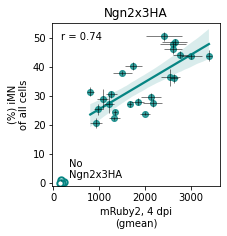

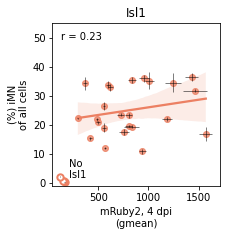

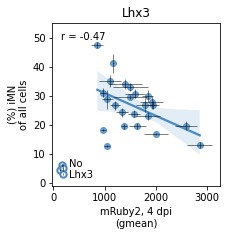

In [36]:
# General plotting params
x = '4dpi mRuby2-A (gmean)'
y = 'iMN percent'
hue = 'uORF'

uORF_list = ['uORFx0', 'uORFwx1', 'uORFx1', 'uORFx2', 'uORFx3', 'uORFx6']
cond_list = ['Ngn2x3HA', 'Isl1', 'Lhx3']
const_list = ['I-L', 'Nx3HA-L', 'Nx3HA-I']
color_list = ['#068583', '#ec8063', '#498ac6']

# Plot eGFP percent of all cells vs. mRuby2
for (i, cond) in enumerate(cond_list):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    # cond = cond_list[i]
    color = color_list[i]

    # Make new df with no const expression ctrl
    noConstData = data_both_reps[(data_both_reps['cond'] ==  cond) & (data_both_reps['const'] ==  'None')]
    noConstData_uORFrename = '{} only\n(no {})'.format(cond, const_list[i])
    noConstData.uORF = noConstData_uORFrename
    # Make new df with only data_both expression ctrl
    onlyConstData = data_both_reps[(data_both_reps['cond'] ==  'No {}'.format(cond)) & (data_both_reps['const'] ==  const_list[i])]
    constData_uORFrename = 'No\n{}'.format(cond)
    onlyConstData.uORF = constData_uORFrename
    onlyConstData.cond = cond

    # Just get current cond data
    df = pd.concat(
        [data_both_reps.loc[(data_both_reps.cond == cond) & (data_both_reps.const == const_list[i])]],
        ignore_index=True)

    # Calc mean and SEM for each cond
    grouping = ['uORF', 'rep', 'CTV_cat']
    data_both_mean = df.groupby(grouping).mean(numeric_only=True).reset_index()
    data_both_SEM = df.groupby(grouping).sem().reset_index()
    data_noConstData_mean = noConstData.groupby(grouping).mean(numeric_only=True).reset_index()
    data_noConstData_SEM = noConstData.groupby(grouping).sem().reset_index()
    data_onlyConstData_mean = onlyConstData.groupby(grouping).mean(numeric_only=True).reset_index()
    data_onlyConstData_SEM = onlyConstData.groupby(grouping).sem().reset_index()

    # Split into hyperP and non
    data_both_mean_hyperP = data_both_mean.loc[data_both_mean.CTV_cat == 'CTV-low']
    data_both_SEM_hyperP = data_both_SEM.loc[data_both_SEM.CTV_cat == 'CTV-low']
    data_noConstData_mean_hyperP = data_noConstData_mean.loc[data_noConstData_mean.CTV_cat == 'CTV-low']
    data_noConstData_SEM_hyperP = data_noConstData_SEM.loc[data_noConstData_SEM.CTV_cat == 'CTV-low']
    data_onlyConstData_mean_hyperP = data_onlyConstData_mean.loc[data_onlyConstData_mean.CTV_cat == 'CTV-low']
    data_onlyConstData_SEM_hyperP = data_onlyConstData_SEM.loc[data_onlyConstData_SEM.CTV_cat == 'CTV-low']
    data_both_mean_nonhyperP = data_both_mean.loc[data_both_mean.CTV_cat == 'non-CTV-low']
    data_both_SEM_nonhyperP = data_both_SEM.loc[data_both_SEM.CTV_cat == 'non-CTV-low']
    data_noConstData_mean_nonhyperP = data_noConstData_mean.loc[data_noConstData_mean.CTV_cat == 'non-CTV-low']
    data_noConstData_SEM_nonhyperP = data_noConstData_SEM.loc[data_noConstData_SEM.CTV_cat == 'non-CTV-low']
    data_onlyConstData_mean_nonhyperP = data_onlyConstData_mean.loc[data_onlyConstData_mean.CTV_cat == 'non-CTV-low']
    data_onlyConstData_SEM_nonhyperP = data_onlyConstData_SEM.loc[data_onlyConstData_SEM.CTV_cat == 'non-CTV-low']

    # Plot main datta
    sns.regplot(ax=ax, data=data_both_mean_hyperP, x=x, y=y, color=color)
    ax.errorbar(x=data_both_mean_hyperP[x], y=data_both_mean_hyperP[y],
            xerr=data_both_SEM_hyperP[x], yerr=data_both_SEM_hyperP[y],
            color='None', ecolor='black', elinewidth=0.5)

    # Plot ctrls
    ax.text(.1, 0.05, constData_uORFrename, transform=ax.transAxes)
    sns.scatterplot(
        ax=ax, data=data_onlyConstData_mean_hyperP, x=x, y=y, 
        color='white', edgecolor=color, s=40, linewidth=2)
    ax.errorbar(
        x=data_onlyConstData_mean_hyperP[x], y=data_onlyConstData_mean_hyperP[y],
        xerr=data_onlyConstData_SEM_hyperP[x], yerr=data_onlyConstData_SEM_hyperP[y],
        color='None', ecolor='black', elinewidth=0.5)

    # Add in Pearson r linear correlation
    r, p = scipy.stats.pearsonr(x=data_both_mean_hyperP[x], y=data_both_mean_hyperP[y])
    ax.text(.05, 0.9, 'r = {:.2f}'.format(r),transform=ax.transAxes)

    # Format
    ax.set_title(cond)
    ax.xaxis.set_label_text('mRuby2, 4 dpi\n(gmean)')
    ax.yaxis.set_label_text('(%) iMN\nof all cells')
    ax.set_yticks(np.arange(0, 55, 10))
    ax.set_ylim(-1, 55)
    # ax.set_xlim(0, 3700)
    
    # plt.savefig(figpath + 'SI/14dpi_iMNpercent_v_4dpi-mRuby2-hyperP_{}_reps_labels.svg'.format(cond), bbox_inches='tight')

### Splitting by bio reps

/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/var/folders/2d/h4qyrjcd68x7g4p2qdv30s8h0000gn/T/ipykernel_55905/1896139514.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onlyConstData['rep'] = onlyConstData['rep'].astype(str)


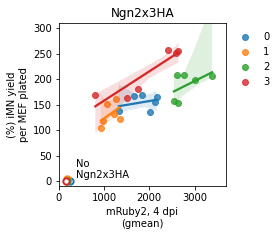

In [37]:
# General plotting params
x = '4dpi mRuby2-A (gmean)'
y = 'iMN yield'
hue = 'uORF'
rep = 3

# uORF_list = ['uORFx3', 'uORFx2', 'uORFx6', 'uORFwx1', 'uORFx0', 'uORFx1']
uORF_list = ['uORFx0', 'uORFwx1', 'uORFx1', 'uORFx2', 'uORFx3', 'uORFx6']
cond_list = ['Ngn2x3HA', 'Isl1', 'Lhx3']
const_list = ['I-L', 'Nx3HA-L', 'Nx3HA-I']
color_list = sns.color_palette(n_colors=len(data_both_reps.rep.unique()))
marker_list = ['o', 's', '^', 'D', 'P', 'X']

# Plot iMN yield vs. mRuby2
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

i = 0
cond = cond_list[i]
color = color_list[i]

# Make new df with no const expression ctrl
noConstData =  data_both_reps[(data_both_reps['cond'] ==  cond) & (data_both_reps['const'] ==  'None')]
noConstData_uORFrename = '{} only\n(no {})'.format(cond, const_list[i])
noConstData.uORF = noConstData_uORFrename
# Make new df with only data_both expression ctrl
onlyConstData = data_both_reps[(data_both_reps['cond'] ==  'No {}'.format(cond)) & (data_both_reps['const'] ==  const_list[i])]
constData_uORFrename = 'No\n{}'.format(cond)
onlyConstData.uORF = constData_uORFrename
onlyConstData.cond = cond
onlyConstData['rep'] = onlyConstData['rep'].astype(str)

# Just get current cond data
df = pd.concat(
    [data_both_reps.loc[(data_both_reps.cond == cond) & (data_both_reps.const == const_list[i])]],
    ignore_index=True)
df['rep'] = df['rep'].astype(str)

# Calc mean and SEM for each cond
grouping = ['uORF', 'rep', 'CTV_cat']
data_both_mean = df.groupby(grouping).mean(numeric_only=True).reset_index()
data_both_SEM = df.groupby(grouping).sem().reset_index()
data_noConstData_mean = noConstData.groupby(grouping).mean().reset_index()
data_noConstData_SEM = noConstData.groupby(grouping).sem().reset_index()
data_onlyConstData_mean = onlyConstData.groupby(grouping).mean().reset_index()
data_onlyConstData_SEM = onlyConstData.groupby(grouping).sem().reset_index()

# Look at hyperP
data_both_mean_hyperP = data_both_mean.loc[data_both_mean.CTV_cat == 'CTV-low']
data_both_SEM_hyperP = data_both_SEM.loc[data_both_SEM.CTV_cat == 'CTV-low']
data_noConstData_mean_hyperP = data_noConstData_mean.loc[data_noConstData_mean.CTV_cat == 'CTV-low']
data_noConstData_SEM_hyperP = data_noConstData_SEM.loc[data_noConstData_SEM.CTV_cat == 'CTV-low']
data_onlyConstData_mean_hyperP = data_onlyConstData_mean.loc[data_onlyConstData_mean.CTV_cat == 'CTV-low']
data_onlyConstData_SEM_hyperP = data_onlyConstData_SEM.loc[data_onlyConstData_SEM.CTV_cat == 'CTV-low']


# Plot main data
rep_list = data_both_mean_hyperP.rep.unique()
for (j, rep) in enumerate(rep_list):
    sns.regplot(ax=ax, data=data_both_mean_hyperP[data_both_mean_hyperP.rep == rep], x=x, y=y,
                color=color_list[j], marker='o', label=rep)

# Plot ctrls
ax.text(.1, 0.05, constData_uORFrename, transform=ax.transAxes)
for (j, rep) in enumerate(rep_list):
    sns.scatterplot(
        ax=ax, data=data_onlyConstData_mean_hyperP.loc[data_onlyConstData_mean_hyperP.rep == rep], 
        x=x, y=y, 
        color='white', edgecolor=color_list[j], s=40, linewidth=2)

# # Format
h,l = ax.get_legend_handles_labels()
sns.move_legend(ax, 
    title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)
ax.set_title(cond)
ax.xaxis.set_label_text('mRuby2, 4 dpi\n(gmean)')
ax.yaxis.set_label_text('(%) iMN yield\nper MEF plated')
ax.set_yticks(np.arange(0, 310, 50))
ax.set_ylim(-10, 310)
ax.set_xlim(0, 3700)
 
# plt.savefig(figpath + 'SI/14dpi_iMNyield_v_4dpi-mRuby2-hyperP_{}_reps_labels_rep{}_v4.svg'.format(cond, rep), bbox_inches='tight')

# Plot iMN yield vs. purity vs. efficiency

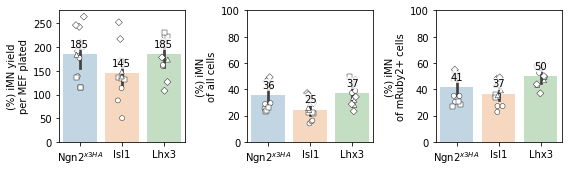

In [38]:
# General plotting params
cond_list = ['Ngn2x3HA', 'Isl1', 'Lhx3']
label_list = ['Ngn2$^{x3HA}$', 'Isl1', 'Lhx3']
const_list = ['I-L', 'Nx3HA-L', 'Nx3HA-I']
color_list = ['#068583', '#ec8063', '#498ac6']
marker_list = ['o', 's', '^', 'D', 'P', 'X']
units = 'well'

# Plot a bunch of things
x = 'cond'
y_list = ['iMN yield', 'iMN percent', 'iMN efficiency']
fig, ax = plt.subplots(1, len(y_list), figsize=(8, 2.5))

# For each cond, plot each y var
for (k, cond) in enumerate(cond_list):
    color = color_list[k]
    df = data_both_reps.loc[(data_both_reps.cond == cond) & (data_both_reps.const == const_list[k])
                                    & (data_both_reps.CTV_cat == 'CTV-low') & (data_both_reps.uORF == 'uORFx0')]

    for (i, y) in enumerate(y_list):
        # Plot
        sns.barplot(ax=ax[i], data=df,
                    x=x, y=y, order=cond_list,
                    units=units,
                    alpha=0.3)
        # Plot bio tech reps
        for (j, rep) in enumerate(df.rep.unique()):
            sns.stripplot(
                ax=ax[i], data=df[df.rep == rep],
                x=x, y=y, order=cond_list,
                dodge=True, marker=marker_list[j],
                color='white', size=5,
                edgecolor='black', linewidth=0.4,)
        
    # Title
    # ax[i].set_title('{} + DDRR'.format(const_list[i]))
    

# Formatting
ylabels = ['(%) iMN yield\nper MEF plated', '(%) iMN\nof all cells', '(%) iMN\nof mRuby2+ cells']

for (i, sub_ax) in enumerate(plt.gcf().get_axes()):
    # Change x axis
    sub_ax.xaxis.set_label_text('')
    # Change y axis
    sub_ax.yaxis.set_label_text(ylabels[i])
    if i != 0:
        sub_ax.set_yticks(np.arange(0, 110, 20))
    sub_ax.xaxis.set_ticklabels(label_list)
    # Add barplot labels
    for i in sub_ax.containers:
        bar_labels = sub_ax.bar_label(i, fmt='%0.0f', padding=5)
        for label in bar_labels:
            label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))

# Format
# plt.suptitle('HG, 14 dpi + DDRR')
fig.tight_layout()  # Helps improve white spacing
plt.savefig(figpath + '14dpi_iMN-yield-percent-efficiency.svg', bbox_inches='tight')

# Plot iMN vs. 14 dpi mRuby2

In [39]:
# Integrate mRuby2 gmean for hyper and non-hyperP at 4 dpi into single df
x = 'mRuby2-A'

group = ['cond', 'const', 'DDRR_cat', 'uORF', 'rep']
data_14dpi_mRuby2_gmean_reps = data_14dpi_mRuby2.groupby(
        [*group, 'well'])[x].apply(scipy.stats.gmean).reset_index(name=x+' (gmean)')

# log10 transform data
data_14dpi_mRuby2_gmean_reps.loc[:, 'log({})'.format(x+' (gmean)')] = np.log10(data_14dpi_mRuby2_gmean_reps[x+' (gmean)'])

# Collapse to bio reps
data_14dpi_mRuby2_gmean = data_14dpi_mRuby2_gmean_reps.groupby([*group]).mean().reset_index()


In [40]:
# Copy dataframe of hyperP/non-hyperP 4 dpi cells that will integrate with the 14 dpi data
data_14dpi_ONLY_reps = data_14dpi_mRuby2_gmean_reps.copy()

# Rename some columns to be clear it's 4 dpi
data_14dpi_ONLY_reps.rename(
    columns={"mRuby2-A (gmean)": "14dpi mRuby2-A (gmean)",
             "log(mRuby2-A (gmean))": "14dpi log(mRuby2-A (gmean))"}, 
    inplace=True
)

# Integrate iMN yield and percent into 4 dpi data
for index, row in data_14dpi_ONLY_reps.iterrows():

    # Get iMN yield
    iMN_yield = data_iMN_yield_reps.loc[
        (data_iMN_yield_reps['rep']==row.rep) & 
        (data_iMN_yield_reps['cond']==row.cond) &
        (data_iMN_yield_reps['const']==row.const) &
        (data_iMN_yield_reps['DDRR_cat']==row.DDRR_cat) &
        (data_iMN_yield_reps['uORF']==row.uORF) & 
        (data_iMN_yield_reps['well']==row.well)
        ]['yield']
    # Get iMN percent
    iMN_percent = data_iMN_percent_reps.loc[
        (data_iMN_percent_reps['rep']==row.rep) & 
        (data_iMN_percent_reps['cond']==row.cond) &
        (data_iMN_percent_reps['const']==row.const) &
        (data_iMN_percent_reps['DDRR_cat']==row.DDRR_cat) &
        (data_iMN_percent_reps['uORF']==row.uORF) & 
        (data_iMN_percent_reps['well']==row.well)
        ]['percent']

    # Integrate in
    # If empty (i.e. wells not collected), skip it
    if len(iMN_yield) == 0:
        continue
    data_14dpi_ONLY_reps.loc[index, 'iMN yield'] = float(iMN_yield)
    data_14dpi_ONLY_reps.loc[index, 'iMN percent'] = float(iMN_percent)
    

/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


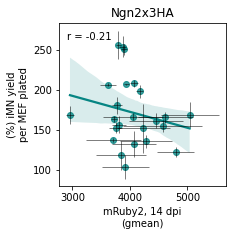

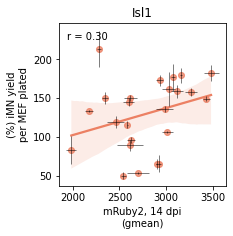

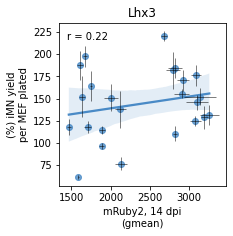

In [41]:
# General plotting params
x = '14dpi mRuby2-A (gmean)'
y = 'iMN yield'
hue = 'uORF'

uORF_list = ['uORFx0', 'uORFwx1', 'uORFx1', 'uORFx2', 'uORFx3', 'uORFx6']
cond_list = ['Ngn2x3HA', 'Isl1', 'Lhx3']
const_list = ['I-L', 'Nx3HA-L', 'Nx3HA-I']
color_list = ['#068583', '#ec8063', '#498ac6']

# Plot eGFP percent of all cells vs. mRuby2
for (i, cond) in enumerate(cond_list):
    # cond = cond_list[i]
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    color = color_list[i]

    # Make new df with no const expression ctrl
    noConstData = data_14dpi_ONLY_reps[(data_14dpi_ONLY_reps['cond'] ==  cond) & (data_14dpi_ONLY_reps['const'] ==  'None')]
    noConstData_uORFrename = '{} only\n(no {})'.format(cond, const_list[i])
    noConstData.uORF = noConstData_uORFrename
    # Make new df with only data_both expression ctrl
    onlyConstData = data_14dpi_ONLY_reps[(data_14dpi_ONLY_reps['cond'] ==  'No {}'.format(cond)) & (data_14dpi_ONLY_reps['const'] ==  const_list[i])]
    constData_uORFrename = 'No\n{}'.format(cond)
    onlyConstData.uORF = constData_uORFrename
    onlyConstData.cond = cond

    # Just get current cond data
    df = pd.concat(
        [data_14dpi_ONLY_reps.loc[(data_14dpi_ONLY_reps.cond == cond) & (data_14dpi_ONLY_reps.const == const_list[i])]],
        ignore_index=True)

    # Calc mean and SEM for each cond
    grouping = ['uORF', 'rep']
    data_both_mean = df.groupby(grouping).mean(numeric_only=True).reset_index()
    data_both_SEM = df.groupby(grouping).sem().reset_index()
    data_noConstData_mean = noConstData.groupby(grouping).mean(numeric_only=True).reset_index()
    data_noConstData_SEM = noConstData.groupby(grouping).sem().reset_index()
    data_onlyConstData_mean = onlyConstData.groupby(grouping).mean(numeric_only=True).reset_index()
    data_onlyConstData_SEM = onlyConstData.groupby(grouping).sem().reset_index()

    # Plot main datta
    sns.regplot(ax=ax, data=data_both_mean, x=x, y=y, color=color)
    ax.errorbar(x=data_both_mean[x], y=data_both_mean[y],
            xerr=data_both_SEM[x], yerr=data_both_SEM[y],
            color='None', ecolor='black', elinewidth=0.5)


    # Add in Pearson r linear correlation
    r, p = scipy.stats.pearsonr(x=data_both_mean[x], y=data_both_mean[y])
    ax.text(.05, 0.9, 'r = {:.2f}'.format(r),transform=ax.transAxes)

    # Format
    ax.set_title(cond)
    ax.xaxis.set_label_text('mRuby2, 14 dpi\n(gmean)')
    ax.yaxis.set_label_text('(%) iMN yield\nper MEF plated')
    
    # plt.savefig(figpath + 'SI/14dpi_iMNyield_v_14dpi-mRuby2_{}_reps_labels.svg'.format(cond), bbox_inches='tight')
